**Recommender Steam Games**

data from [Kaggle](https://www.kaggle.com/datasets/tamber/steam-video-games?fbclid=IwAR1CvNiSmCrXNLDdDLfnzqWhMaP0Ryi_pNGH_iJL-7dx5lHfeI5k_bAQt-Q)

This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, value. The behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

Load data and display table

In [2]:
df = pd.read_csv("data/steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])
df = df.drop(columns='Other')
df

,UserID,Game,Action,Hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0


In [3]:
df.dtypes

UserID      int64
Game       object
Action     object
Hours     float64
dtype: object

In [4]:
#number of games
df.Game.nunique()

5155

In [5]:
#number of users
df.UserID.nunique()

12393

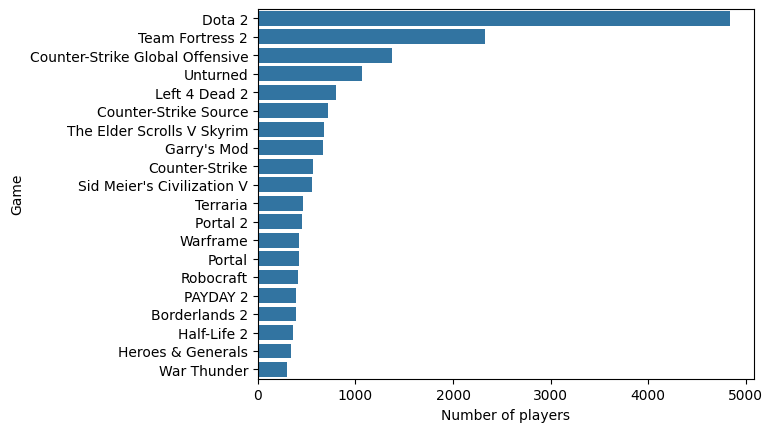

In [6]:
#plot game - nummber of players
games_to_display = 20

game_counts = df[df['Action']=='play'].groupby('Game')['Game'].agg('count').sort_values(ascending=False)
game_counts = pd.DataFrame({'Game': game_counts.index, 'Number of players': game_counts.values})[0:games_to_display]
sns.barplot(y = 'Game', x = 'Number of players', data = game_counts)
print()

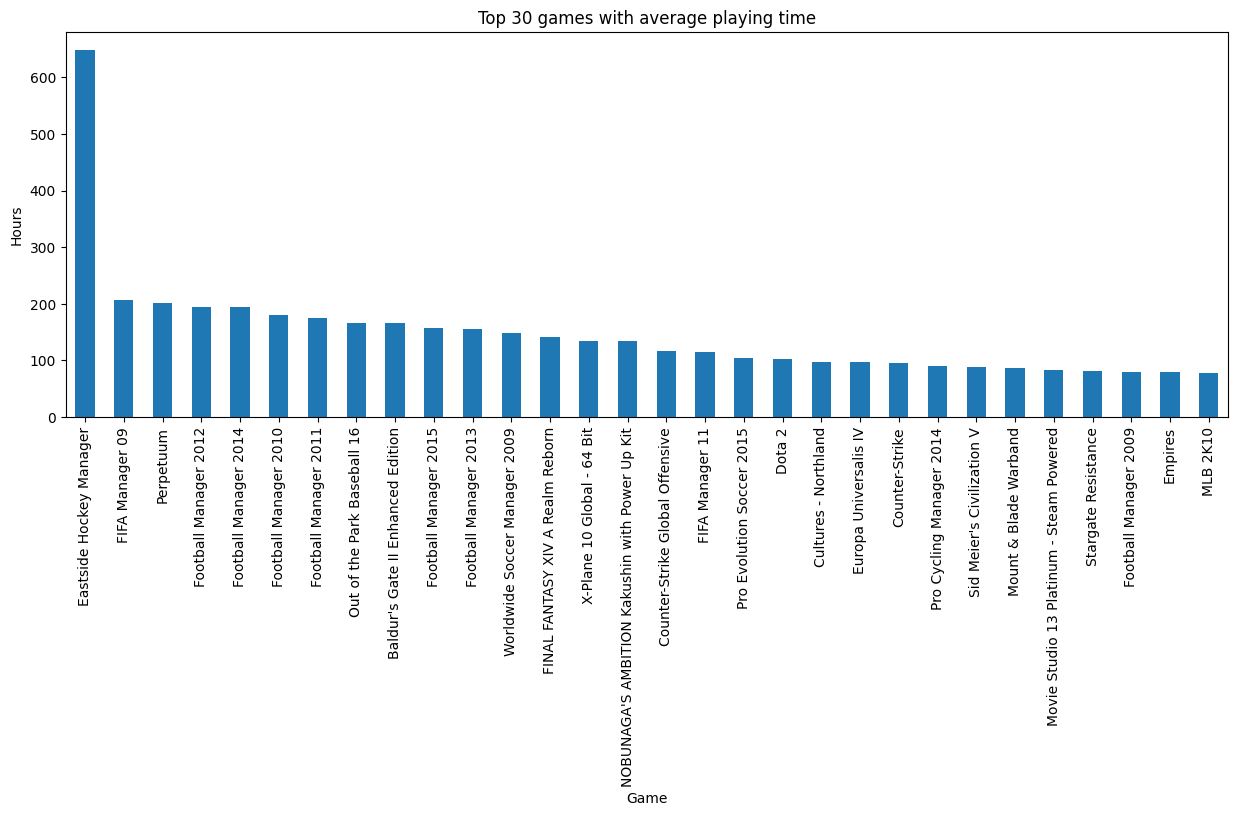

In [7]:
games_to_display =30

user_counts = df.groupby('Game')['Hours'].agg(np.average).sort_values(ascending=False)
user_counts = pd.DataFrame({'Game': user_counts, 'hours': user_counts.values})[0:games_to_display]
user_counts['hours'].plot.bar(figsize=(15,5))
plt.title(f'Top {games_to_display} games with average playing time')
plt.ylabel('Hours')
print()

/tmp/ipykernel_15932/3249208509.py:2: FutureWarning: The provided callable <function sum at 0x702ab429d000> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)


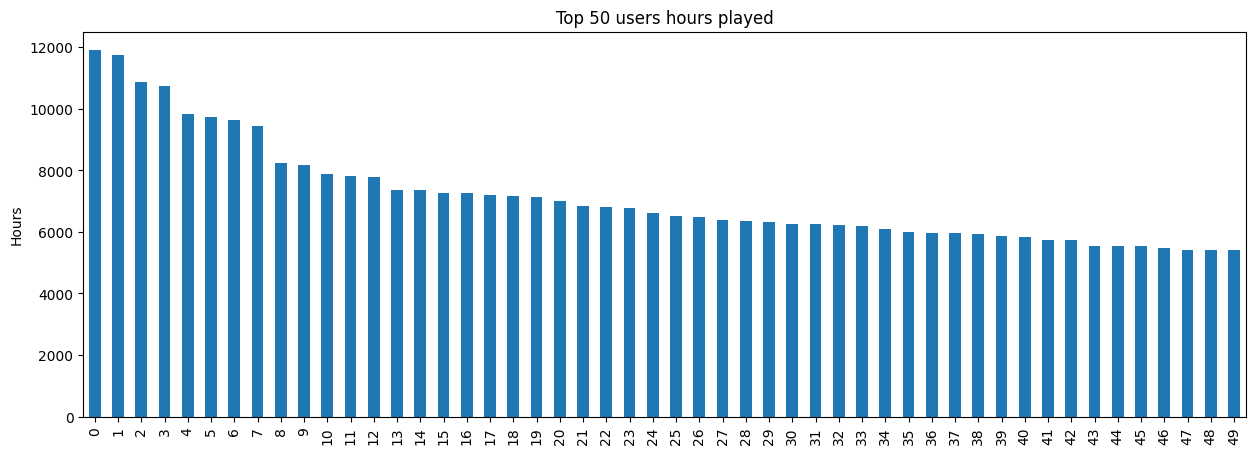

In [8]:
#Top 50 user and theirs play time
user_counts = df.groupby('UserID')['Hours'].agg(np.sum).sort_values(ascending=False)
user_counts = pd.DataFrame({'user': user_counts.index, 'hours': user_counts.values})[0:50]
user_counts['hours'].plot.bar(figsize=(15,5))
plt.title('Top 50 users hours played')
plt.ylabel('Hours')
print()

/tmp/ipykernel_15932/3105864573.py:6: FutureWarning: The provided callable <function sum at 0x702ab429d000> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  sum_hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
/tmp/ipykernel_15932/3105864573.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(width=.4, x="Hours", y="Game", data=df_for_boxplot_pre, palette="Set3", order=top_played['Game'])


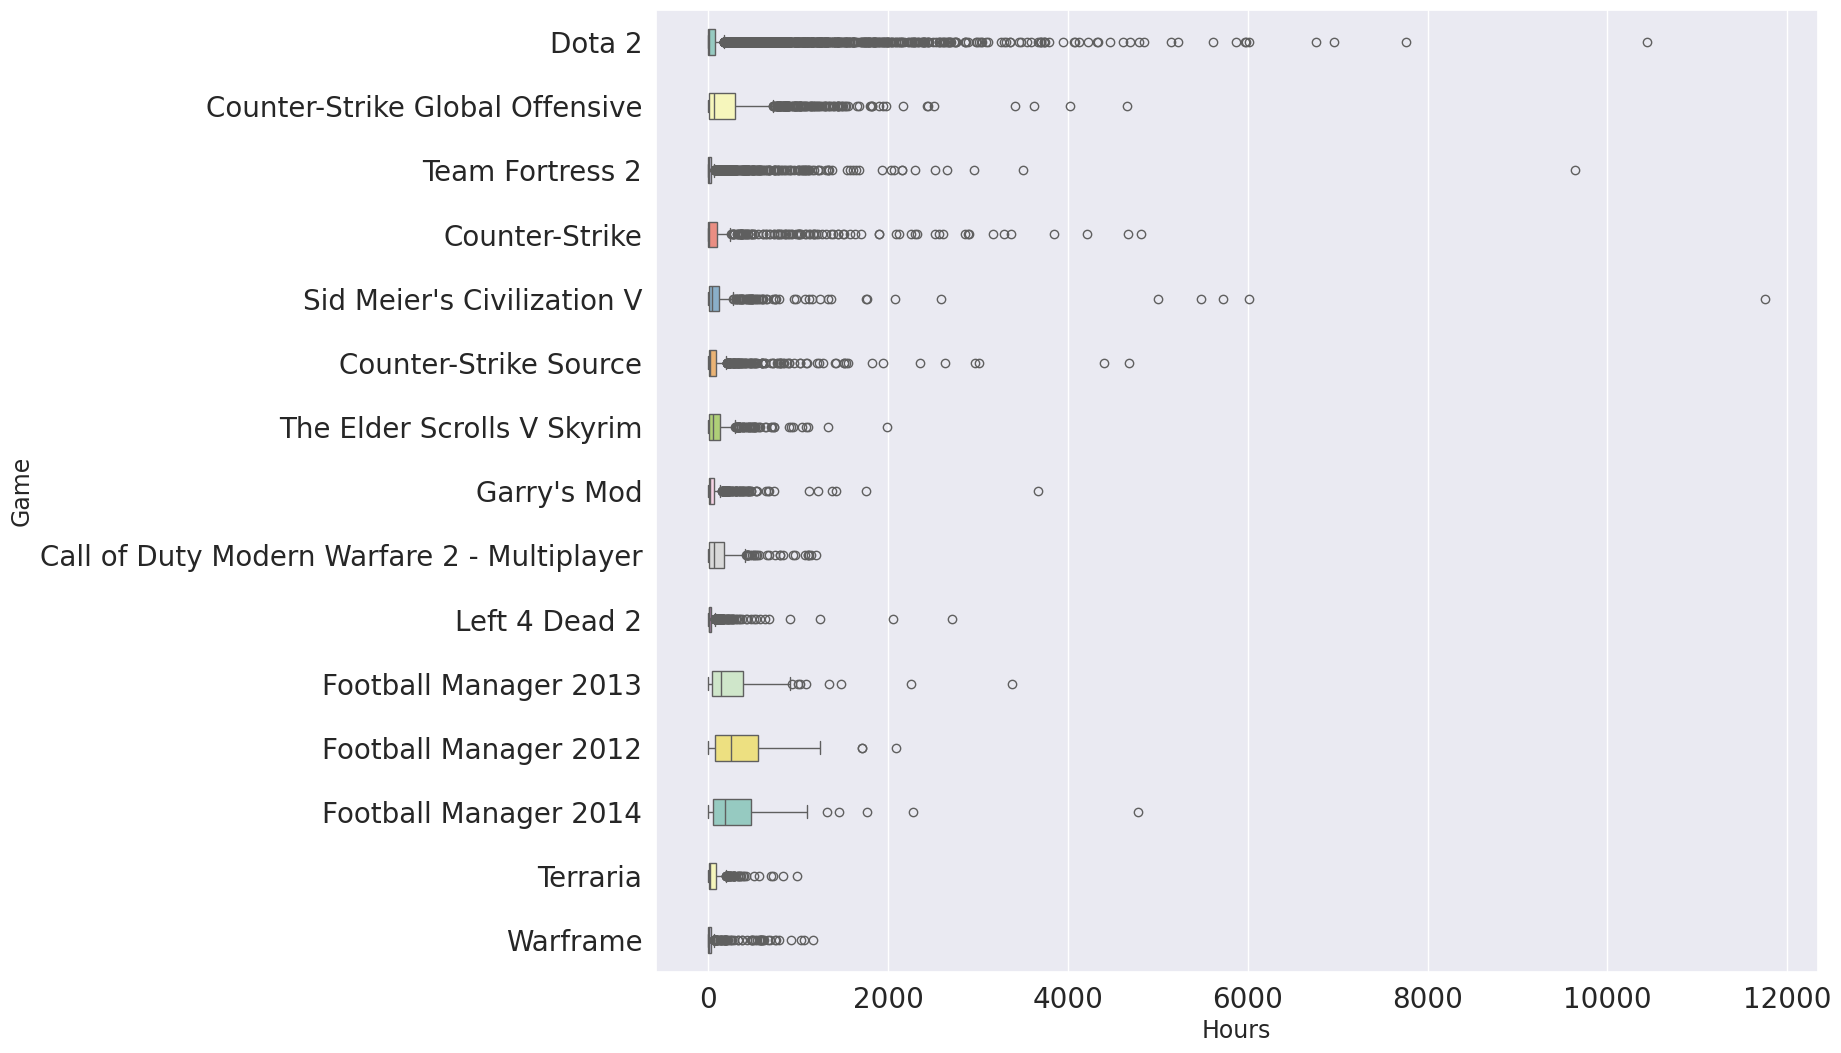

In [9]:
#Distribution of playing time and users for top <15> games
games_to_display = 15


df_play = df.loc[df['Action'] == 'play']
sum_hours_played = df_play.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
top_played = pd.DataFrame({'Game': sum_hours_played.index, 'Game Hours': sum_hours_played.values})[0:games_to_display]


df_only_played = df.loc[df['Action'] == 'play']

mask = df_only_played['Game'].isin(top_played['Game'])

df_for_boxplot_pre = df.loc[df['Action'] == 'play'].loc[mask][['Hours', 'Game']]

sns.set(rc={'axes.labelsize':17,
            'figure.figsize':(15.0, 5 + games_to_display/2),
           'xtick.labelsize':20,
            'ytick.labelsize':20})

boxplot = sns.boxplot(width=.4, x="Hours", y="Game", data=df_for_boxplot_pre, palette="Set3", order=top_played['Game'])
fig = boxplot.get_figure()

/tmp/ipykernel_15932/3356609514.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(width=.4, x="Hours", y="Game", data=df_for_boxplot_pre, palette="Set3", order=top_played['Game'])


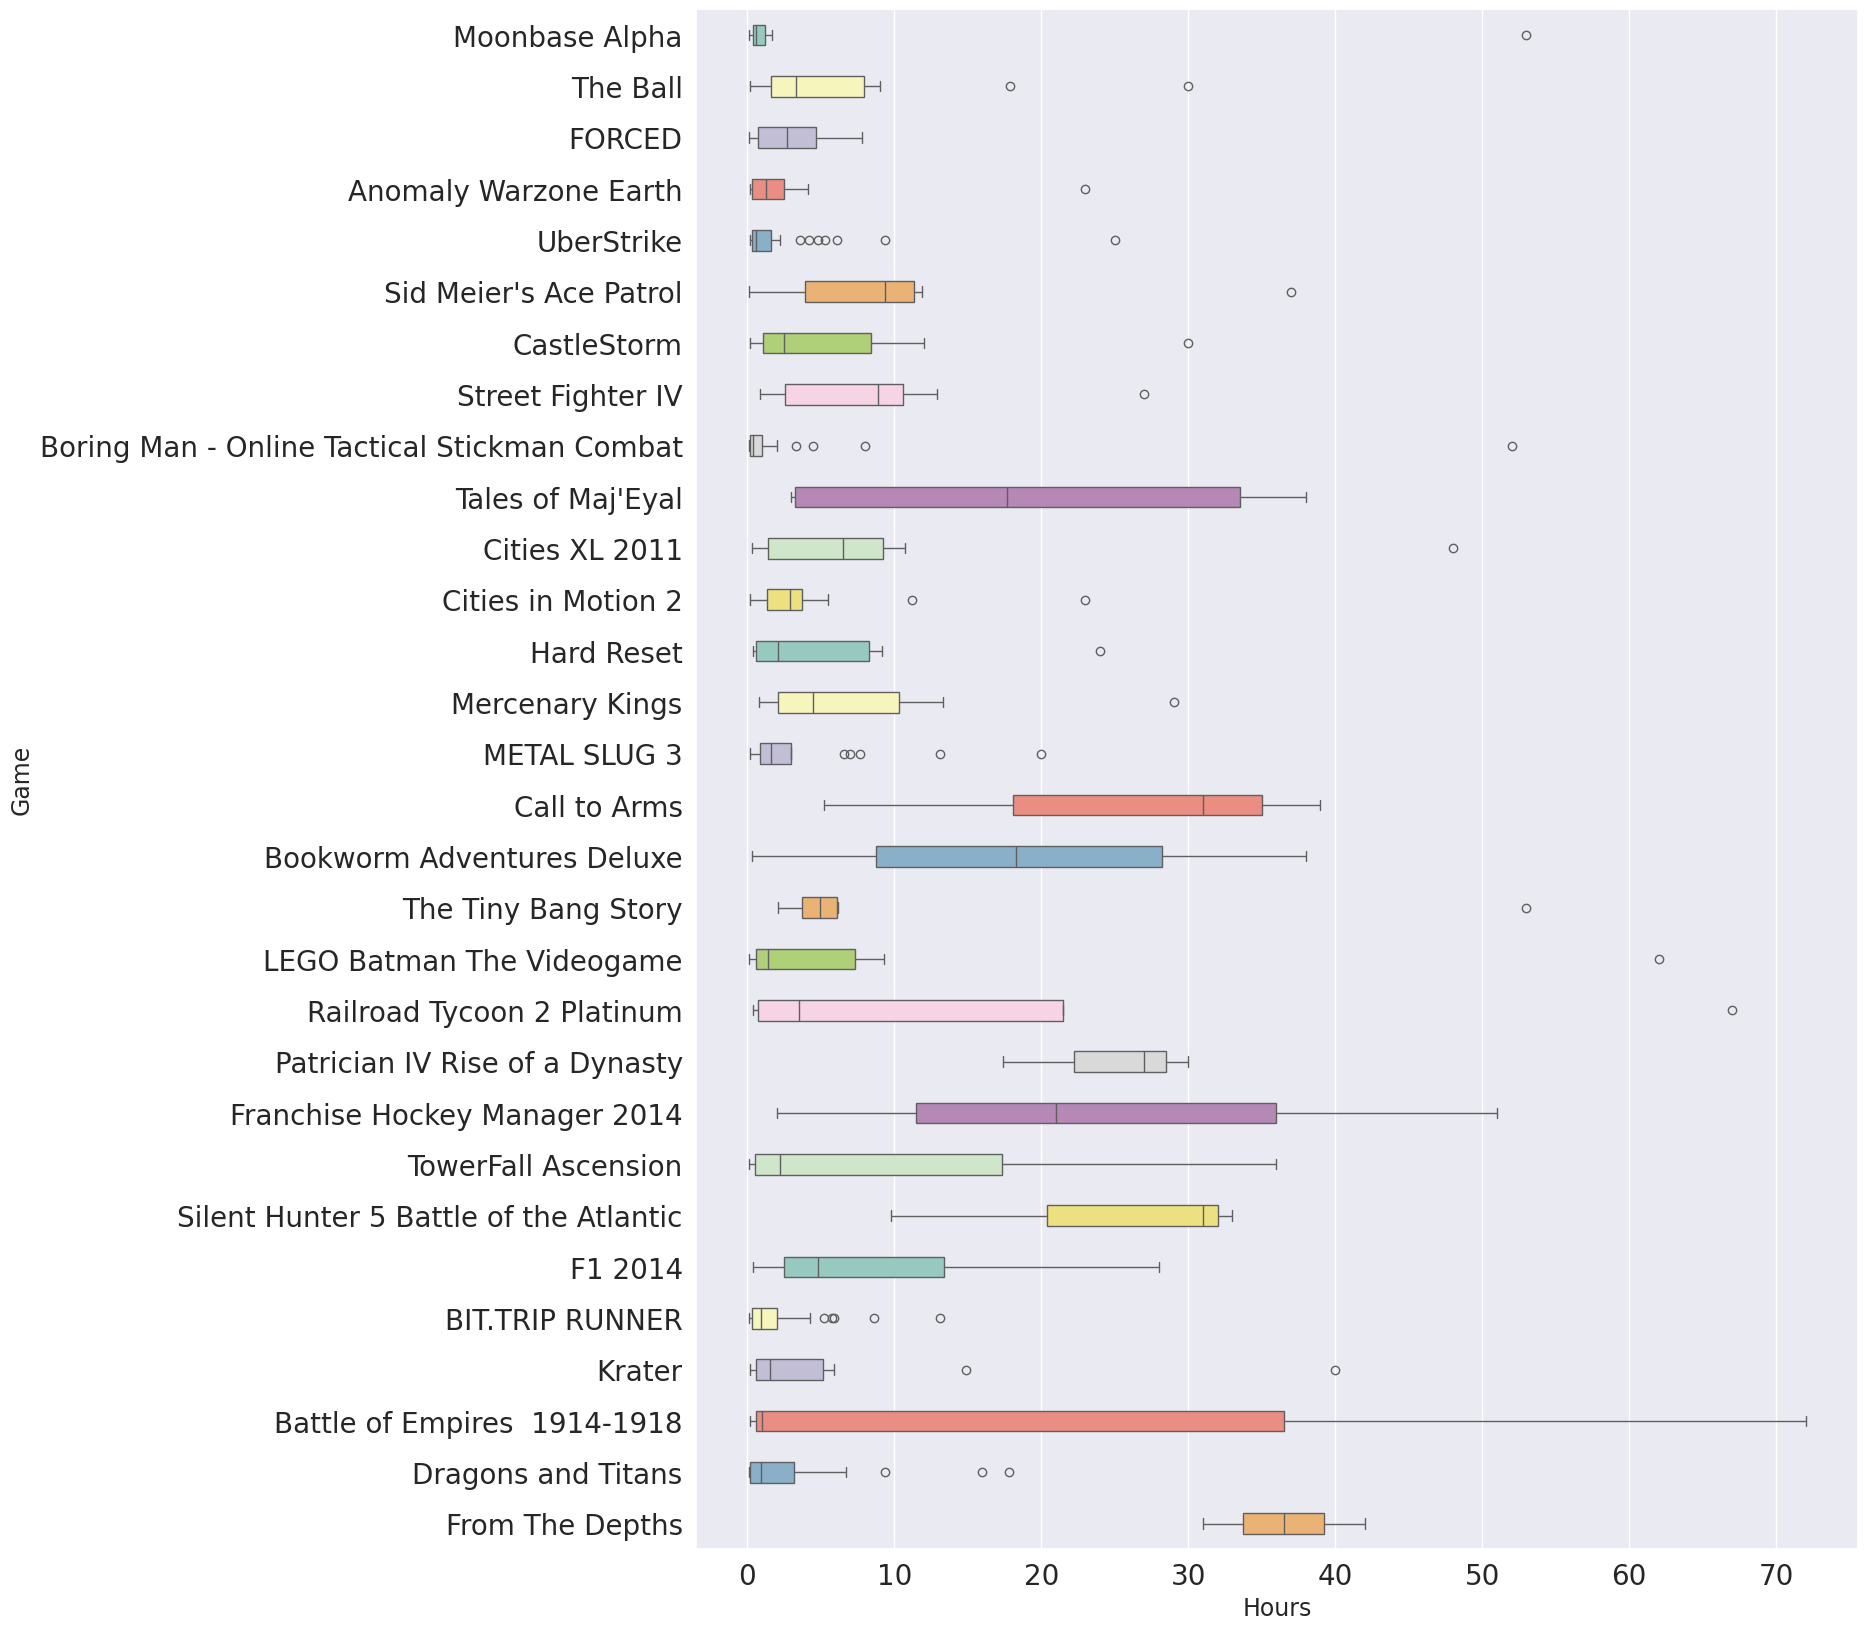

In [10]:
top_played = pd.DataFrame({'Game': sum_hours_played.index, 'Game Hours': sum_hours_played.values})[1000:1030]


df_only_played = df.loc[df['Action'] == 'play']

mask = df_only_played['Game'].isin(top_played['Game'])

df_for_boxplot_pre = df.loc[df['Action'] == 'play'].loc[mask][['Hours', 'Game']]

sns.set(rc={'axes.labelsize':17,
            'figure.figsize':(15.0, 20),
           'xtick.labelsize':20,
            'ytick.labelsize':20})

boxplot = sns.boxplot(width=.4, x="Hours", y="Game", data=df_for_boxplot_pre, palette="Set3", order=top_played['Game'])
fig = boxplot.get_figure()

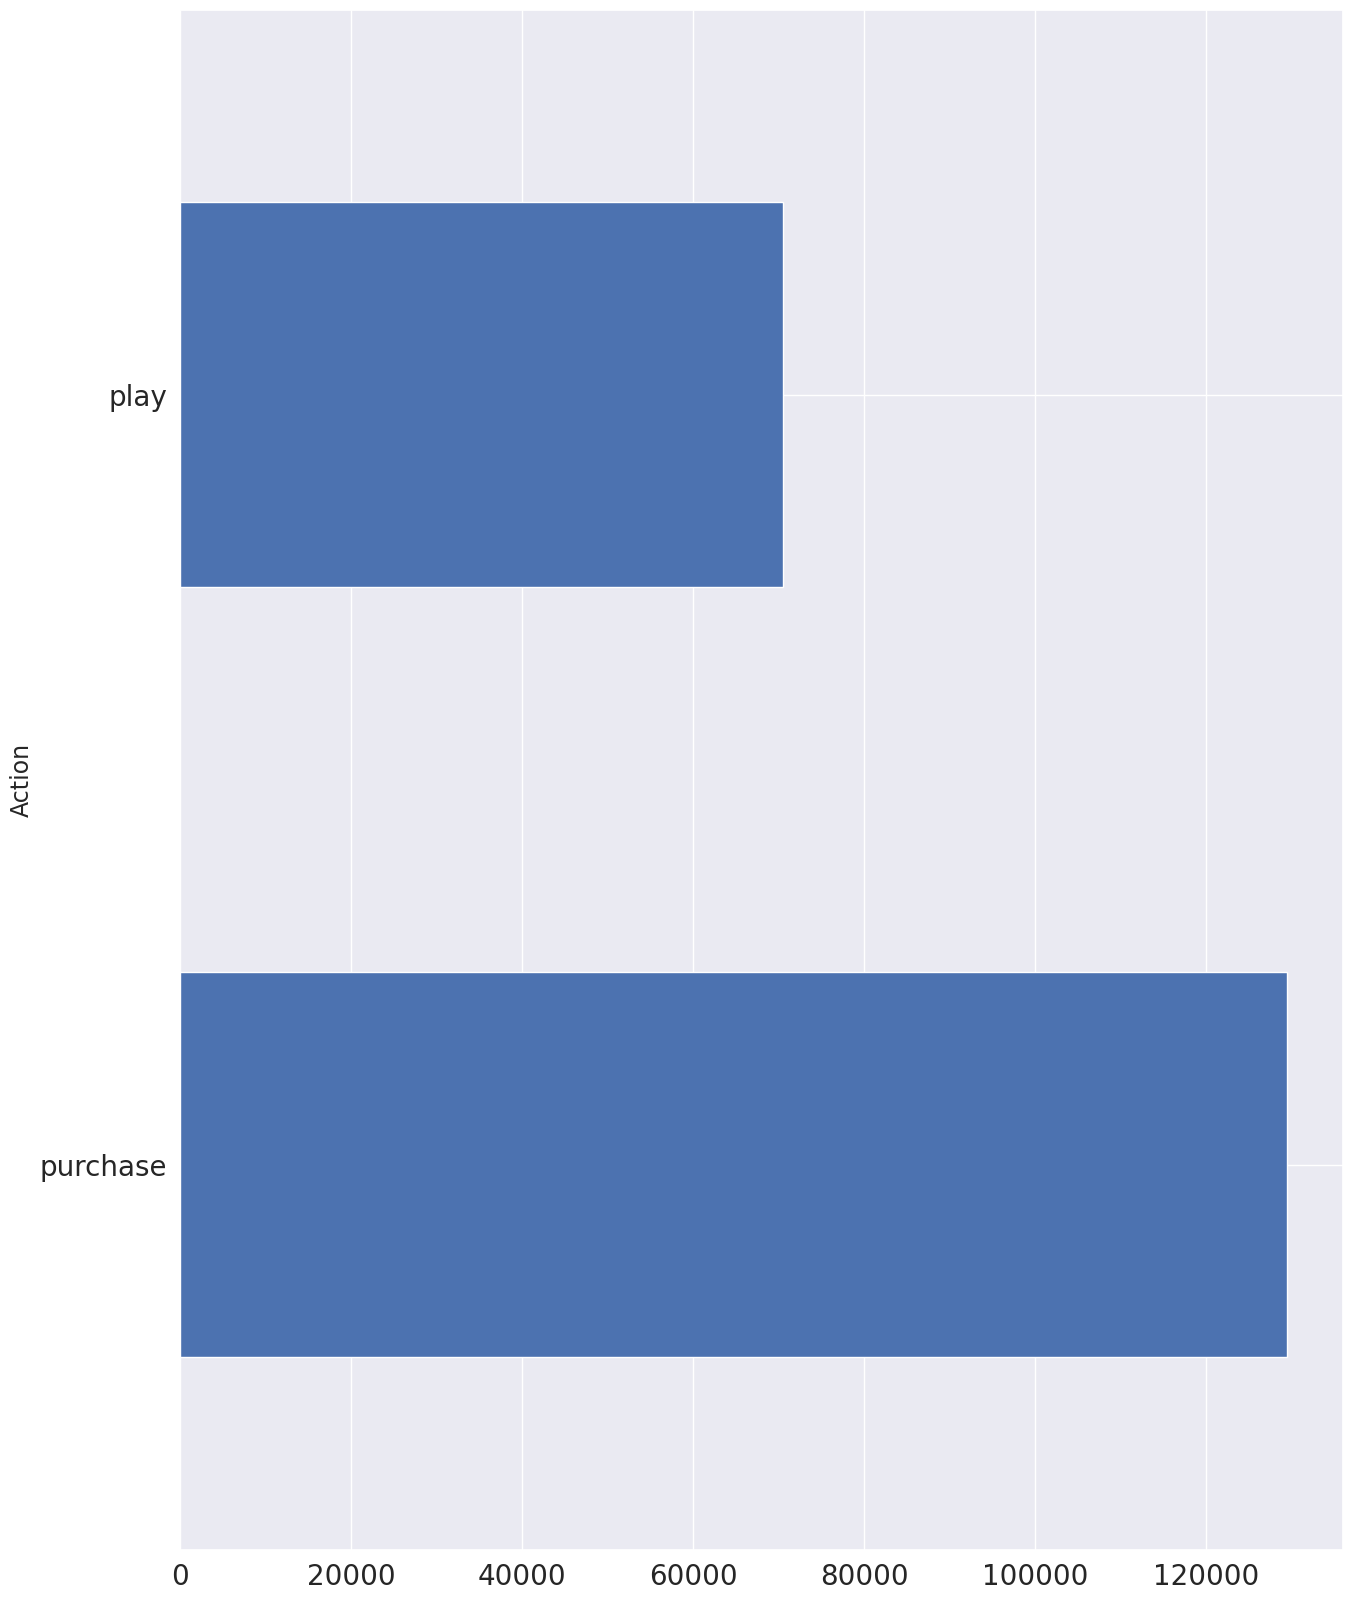

In [11]:
df["Action"].value_counts().plot.barh();

Getting steamID data for the games

In [12]:
import requests

def get_request(url, parameters=None):
    """Return json-formatted response of a get request using optional parameters.
    
    Parameters
    ----------
    url : string
    parameters : {'parameter': 'value'}
        parameters to pass as part of get request
    
    Returns
    -------
    json_data
        json-formatted response (dict-like)
    """
    try:
        response = requests.get(url=url, params=parameters)
    except SSLError as s:
        print('SSL Error:', s)
        
        for i in range(5, 0, -1):
            print('\rWaiting... ({})'.format(i), end='')
            time.sleep(1)
        print('\rRetrying.' + ' '*10)
        
        # recusively try again
        return get_request(url, parameters)
    
    if response:
        return response.json()
    else:
        # response is none usually means too many requests. Wait and try again 
        print('No response, waiting 10 seconds...')
        time.sleep(10)
        print('Retrying.')
        return get_request(url, parameters)


In [13]:
urlAppIDList = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
parametersAppIDList = {"request": "all"}

json_data = get_request(urlAppIDList, parameters=parametersAppIDList)["applist"]["apps"]
all_steam_apps = pd.DataFrame(json_data)

all_steam_apps

,appid,name
0,216938,Pieterw test app76 ( 216938 )
1,660010,test2
2,660130,test3
3,1118314,
4,1275822,
...,...,...
193788,2443780,Settlemoon
193789,2882000,Hidden Cosmo Cats - Soundtrack
193790,2537730,Noblesse Oblige: Legacy of the Sorcerer Kings
193791,2896680,Scorpion's Curse Demo


In [14]:
def get_app_id_from_name(name):
    return all_steam_apps[all_steam_apps['name'] == name]["appid"].values[0]

In [15]:
def get_app_categories(name):
    appID = get_app_id_from_name(name)
    urlAppID = "https://store.steampowered.com/api/appdetails?appids=" + str(appID)
    
    parametersAppID = {"filter": "all", "language": "en", "day_range": "1000000", "cursor": "*", 
              "review_type": "all", "purchase_type": "all", "num_per_page": "100"}
    
    json_data = get_request(urlAppID, parameters=parametersAppID)[str(appID)]['data']['categories']
    
    return json_data

    

In [16]:
get_app_categories("Age of Empires III: Definitive Edition")

[{'id': 2, 'description': 'Single-player'},
 {'id': 1, 'description': 'Multi-player'},
 {'id': 49, 'description': 'PvP'},
 {'id': 36, 'description': 'Online PvP'},
 {'id': 47, 'description': 'LAN PvP'},
 {'id': 27, 'description': 'Cross-Platform Multiplayer'},
 {'id': 22, 'description': 'Steam Achievements'},
 {'id': 29, 'description': 'Steam Trading Cards'},
 {'id': 23, 'description': 'Steam Cloud'}]

# Problem formulation

The objective is to generate a model which would take the data about the user(purchased games, play time on other games) and give out possible recommendations for new obscure/not-so-popular games.

The model would be suitable for helping smaller video game development teams become more visible/the players would be exposed to more unusual/exotic content. 



# Algorithm proposal

Content-based apporach would be used: based on the purchased games and the corresponding playtimes, profile for each user would be built, also all video games would be defined by tags and similar users played it. Based on those two, the game would be recommended. (collaborative filtering)

# Evaluation 

From the original data about the users, one part would be kept to be used as test data(if hours played is high enough(to be defined) then the example would be positive), algorithm would be evaluated by the accuracy on that set. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78127b5c-ed01-400f-a599-d5a1fd275b19' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>